In [1]:
import json
import numpy as np
from math import log
import pandas as pd
import os

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)


In [2]:
name = "uni"

invasive_path = os.path.join(config['retrained_benchmark_folder2'], 
                                  "invasive_cancer_clustering",
                                   "kmeans")

In [3]:
optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)


In [4]:
import glob

filename = glob.glob(os.path.join(invasive_path,
                                    name, 
                                    f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
df = pd.read_csv(filename, index_col=0)

In [5]:
metadata = pd.read_excel("/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/ST_TNBC_metadata.xlsx")

In [6]:
metadata["OS-event"]

0     0.0
1     0.0
2     1.0
3     0.0
4     0.0
     ... 
89    0.0
90    0.0
91    0.0
92    0.0
93    0.0
Name: OS-event, Length: 94, dtype: float64

In [7]:
metadata["OS_years"]

0      8.284932
1     11.282192
2      2.375342
3      5.156164
4      6.756164
        ...    
89    20.186301
90    15.769863
91     3.183562
92     5.065753
93     7.520548
Name: OS_years, Length: 94, dtype: float64

In [8]:
metadata["above_56"] = (metadata["Age_at_diagnosis"] > 56).astype(int)

In [9]:
metadata["Age_at_diagnosis"].min()

24

In [10]:
metadata["Age_at_diagnosis"].describe()

count    94.00000
mean     56.12766
std      15.09485
min      24.00000
25%      43.25000
50%      56.00000
75%      68.00000
max      87.00000
Name: Age_at_diagnosis, dtype: float64

In [11]:
# Statistical test: Log-rank test to compare survival curves
from lifelines.statistics import logrank_test

# Prepare data
data_km = metadata[['OS_years', 'OS-event', 'above_56']].dropna()

# Separate groups
group_young = data_km[data_km['above_56'] == 0]
group_old = data_km[data_km['above_56'] == 1]

# Perform log-rank test
results = logrank_test(
    group_young['OS_years'], 
    group_old['OS_years'],
    event_observed_A=group_young['OS-event'],
    event_observed_B=group_old['OS-event']
)

print("Log-rank test results:")
print(f"Test statistic: {results.test_statistic:.4f}")
print(f"P-value: {results.p_value:.4f}")
print(f"Significance: {'Yes' if results.p_value < 0.05 else 'No'} (α = 0.05)")

Log-rank test results:
Test statistic: 10.2897
P-value: 0.0013
Significance: Yes (α = 0.05)


In [12]:
# Extract patient IDs from the spot names in df
# Assuming spot names have format like "TNBC78_1x2" where "TNBC78" is the patient ID
df['patient_id'] = df.index.str.split('_').str[0]

# Count spots per cluster per patient
cluster_counts = df.groupby(['patient_id', 'predicted_label']).size().reset_index(name='count')

# Calculate total spots per patient
total_spots = df.groupby('patient_id').size().reset_index(name='total')

# Merge and calculate percentages
cluster_composition = cluster_counts.merge(total_spots, on='patient_id')
cluster_composition['percentage'] = (cluster_composition['count'] / cluster_composition['total']) * 100

# Pivot to get one row per patient with columns for each cluster
cluster_composition_wide = cluster_composition.pivot(
    index='patient_id', 
    columns='predicted_label', 
    values='percentage'
).fillna(0)

# Rename columns to be more descriptive
cluster_composition_wide.columns = [f'cluster_{col}_pct' for col in cluster_composition_wide.columns]

print(f"Cluster composition for {len(cluster_composition_wide)} patients:")
cluster_composition_wide

Cluster composition for 85 patients:


,cluster_0_pct,cluster_1_pct,cluster_2_pct,cluster_3_pct,cluster_4_pct
patient_id,,,,,
TNBC1,22.131148,3.278689,59.836066,14.754098,0.000000
TNBC11,96.975425,0.378072,1.512287,1.134216,0.000000
TNBC12,2.061856,3.092784,19.587629,75.257732,0.000000
TNBC13,0.000000,0.000000,100.000000,0.000000,0.000000
TNBC14,0.000000,54.684096,3.159041,42.156863,0.000000
...,...,...,...,...,...
TNBC92,3.136955,13.159908,0.918133,82.785004,0.000000
TNBC93,0.057604,4.608295,0.288018,0.979263,94.066820
TNBC94,90.348101,0.474684,2.215190,6.882911,0.079114


In [13]:
# Merge cluster composition with clinical metadata
# First, match patient IDs between cluster data and metadata
metadata['patient_id'] = metadata['ST_TNBC_ID'].apply(lambda x: f"TNBC{x}")  # Adjust column name if needed



Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct']


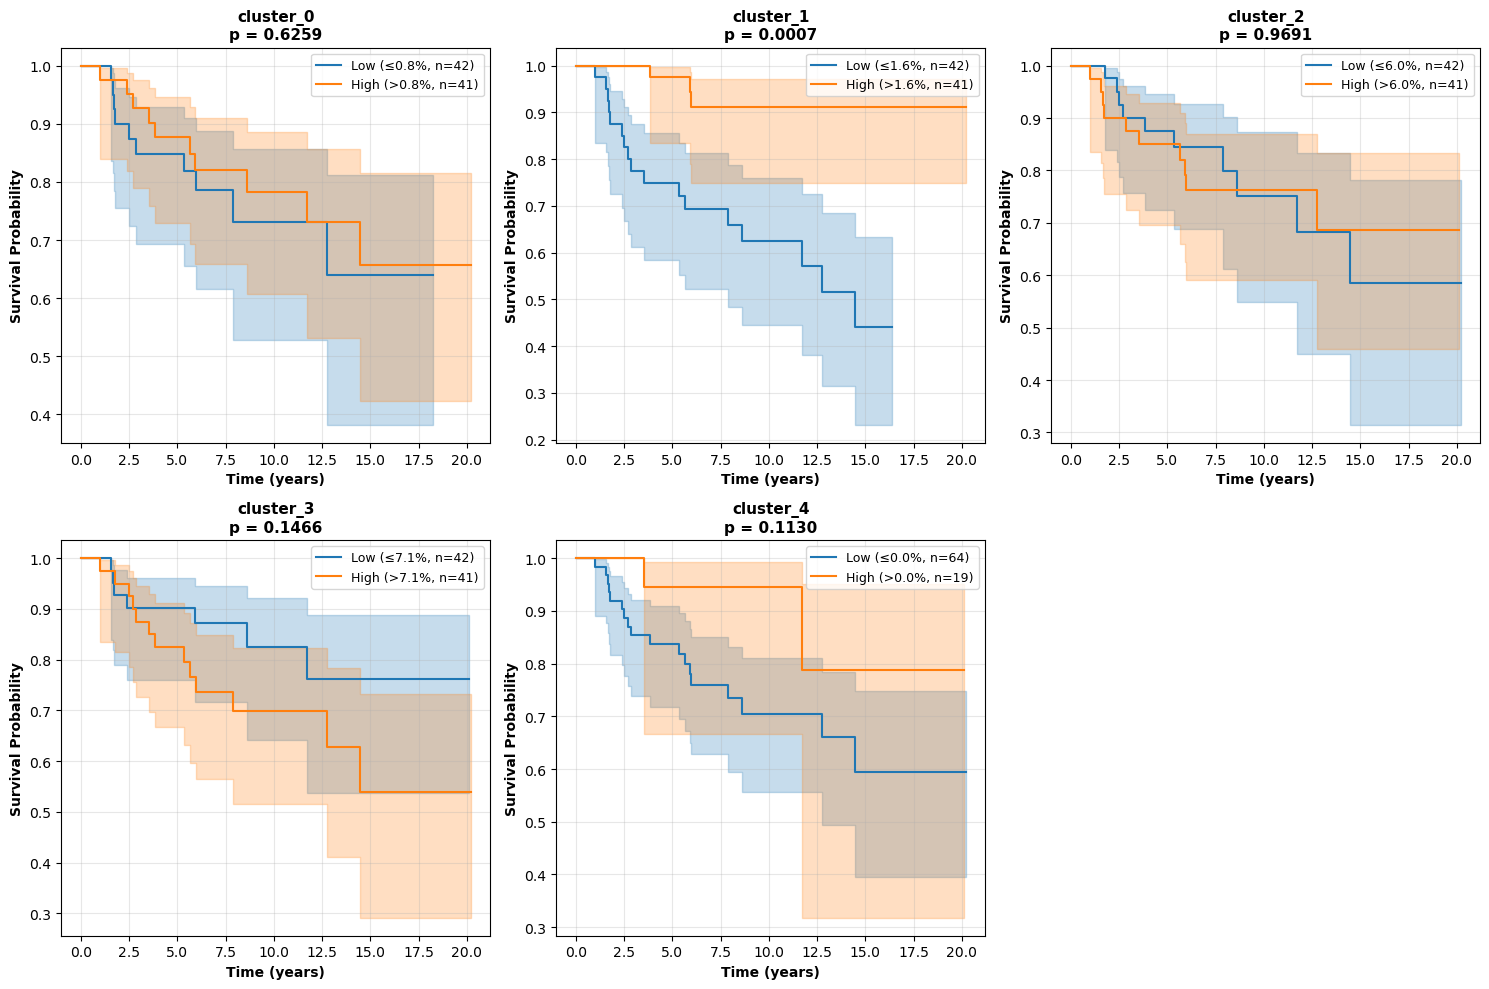


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,0.789889,42,41,0.625878,0.237693
1,cluster_1,1.556420,42,41,0.000716,11.447539
2,cluster_2,5.972046,42,41,0.969141,0.001497
3,cluster_3,7.142857,42,41,0.146598,2.107294
4,cluster_4,0.000000,64,19,0.113026,2.511386


In [14]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['OS_years', 'OS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['OS_years'], 
            low_group['OS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['OS_years'], 
            high_group['OS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['OS_years'], 
        high_group['OS_years'],
        event_observed_A=low_group['OS-event'],
        event_observed_B=high_group['OS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

In [15]:
from lifelines import CoxPHFitter

In [16]:
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]
df = patient_data.dropna()

# Handle zeros and normalize
df[cluster_cols] = df[cluster_cols].clip(lower=1e-6)
df[cluster_cols] = df[cluster_cols].div(df[cluster_cols].sum(axis=1), axis=0)

# CLR transform
log_vals = np.log(df[cluster_cols])
clr_vals = log_vals.sub(log_vals.mean(axis=1), axis=0)
clr_df = clr_vals.add_suffix("_clr")

# Combine with survival data
cox_df = pd.concat([df[["OS_years","OS-event"]], clr_df], axis=1)

/tmp/ipykernel_2723987/583869532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cluster_cols] = df[cluster_cols].clip(lower=1e-6)
/tmp/ipykernel_2723987/583869532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cluster_cols] = df[cluster_cols].div(df[cluster_cols].sum(axis=1), axis=0)


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 83 total observations, 63 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
cluster_0_pct_clr            0.20 0.65      0.61
cluster_1_pct_clr            0.00 0.97      0.04
cluster_2_pct_clr            1.02 0.31      1.67
cluster_3_pct_clr            0.01 0.94      0.09
cluster_4_pct_clr            0.11 0.74      0.44


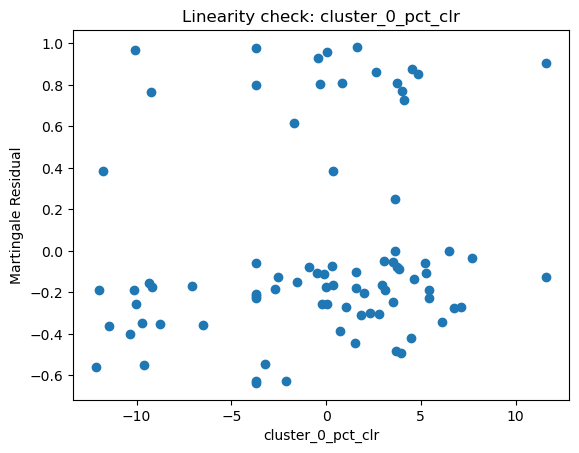

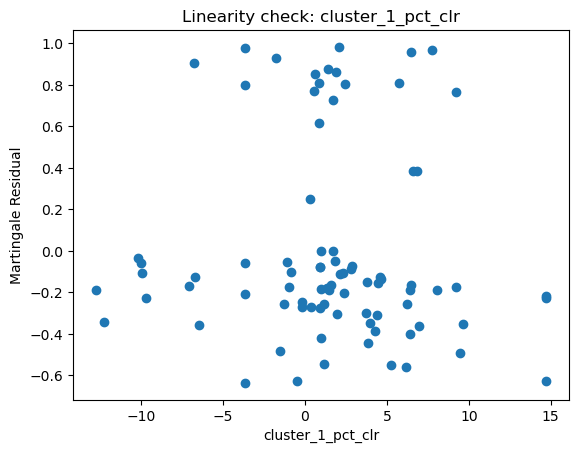

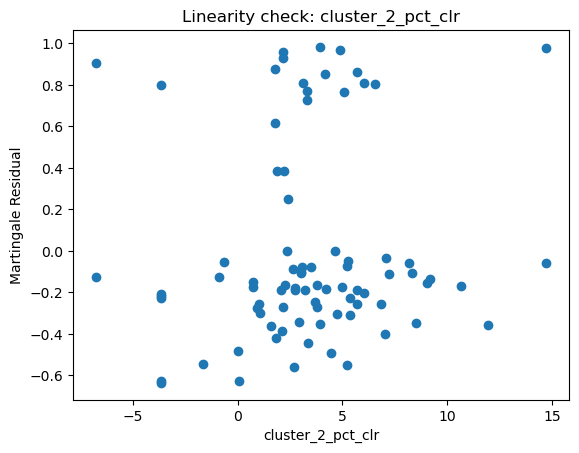

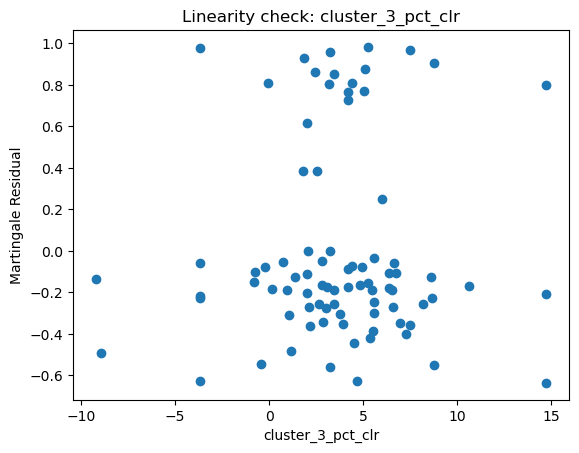

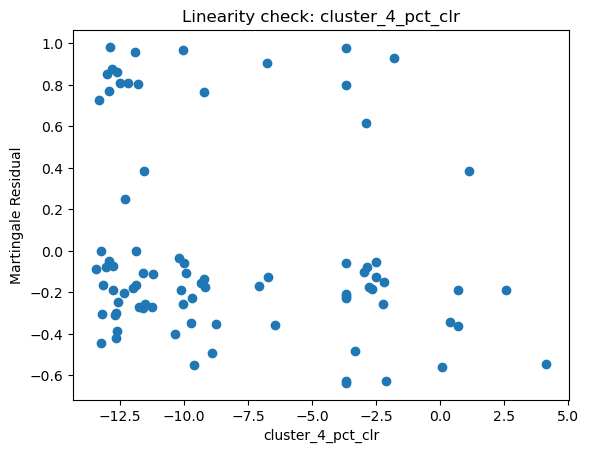

In [17]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

# Fit Cox model (with or without penalizer)
cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_df, duration_col="OS_years", event_col="OS-event")

# Check proportional hazards assumption
results = proportional_hazard_test(cph, cox_df, time_transform='rank')
print(results)

residuals = cph.compute_residuals(cox_df, kind='martingale')
for col in clr_df.columns:
    plt.scatter(cox_df[col], residuals['martingale'])
    plt.xlabel(col)
    plt.ylabel("Martingale Residual")
    plt.title(f"Linearity check: {col}")
    plt.show()

In [18]:

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 83 total observations, 63 right-censored observations>
             duration col = 'OS_years'
                event col = 'OS-event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 83
number of events observed = 20
   partial log-likelihood = -76.18
         time fit was run = 2025-11-26 13:33:32 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
cluster_0_pct_clr   0.00       1.00       0.04            -0.08             0.08                 0.93                 1.09
cluster_1_pct_clr  -0.01       0.99       0.04            -0.09             0.07                 0.91                 1.08
cluster_2_pct_clr  -0.04       0.96       0.05            -0.14             0.07                 0.87                 1.07
cluster_3_pct_clr   0.10       1.11       0.05            -0.00             0.21                 1.00                 1.23
cluster_4_pct_clr  -0.04       0.96       0.05            -0.13             0.05                 0.87                 1.05

                    cmp to     z    p   -log2(p)
covariate                                       
cluster_0_pct_clr     0.00  0.07 0.94       0.08
cluster_1_pct_clr     0.00 -0.22 0.82       0.28
cluster_2_pct_clr     0.00 -0.72 0.47       1.09
cluster_3_pct_clr     0.00  1.88 0.06       4.06
cluster_4_pct_clr     0.00 -0.89 0.37       1.43
---
Concordance = 0.65
Partial AIC = 162.36
log-likelihood ratio test = 6.99 on 5 df
-log2(p) of ll-ratio test = 2.18

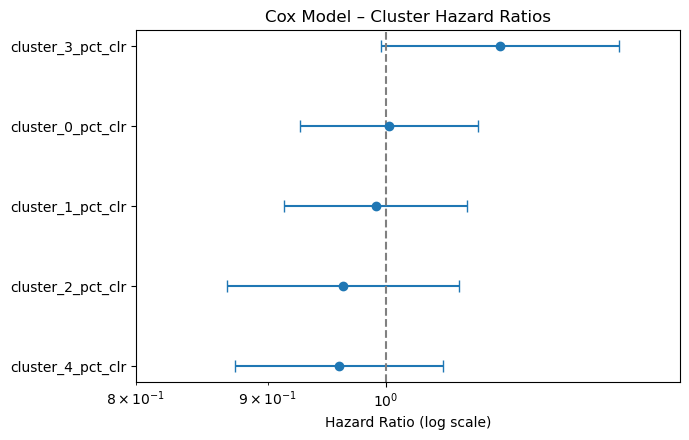

In [23]:
import numpy as np
import matplotlib.pyplot as plt

summary = cph.summary.copy()
summary = summary.sort_values("exp(coef)")  # Order visually

hr = summary["exp(coef)"]
ci_lower = summary["exp(coef) lower 95%"]
ci_upper = summary["exp(coef) upper 95%"]
labels = summary.index

plt.figure(figsize=(7, 4.5))
plt.errorbar(hr, labels, 
             xerr=[hr-ci_lower, ci_upper-hr], 
             fmt='o', capsize=4)

plt.axvline(1, color='grey', linestyle='--')
plt.xlabel("Hazard Ratio (log scale)")
plt.xscale("log")
plt.title("Cox Model – Cluster Hazard Ratios")
plt.xlim(0.8, 1.3)

plt.tight_layout()
plt.show()

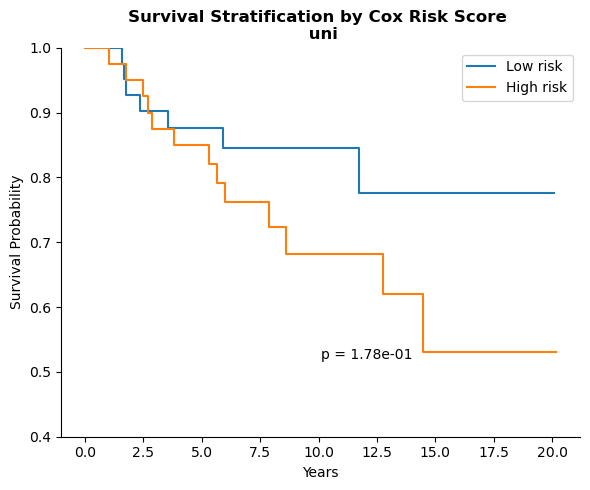

In [26]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn as sns
# Compute risk score (linear predictor)
cox_df["risk_score"] = cph.predict_partial_hazard(cox_df)

# Stratify into High vs Low using median
median = cox_df["risk_score"].median()
cox_df["risk_group"] = np.where(cox_df["risk_score"] > median, "High risk", "Low risk")

# Fit KMF curves
km = KaplanMeierFitter()

plt.figure(figsize=(6, 5))

for group in ["Low risk", "High risk"]:
    mask = cox_df["risk_group"] == group
    km.fit(cox_df.loc[mask, "OS_years"],
           cox_df.loc[mask, "OS-event"],
           label=group)
    km.plot(ci_show=False)

plt.title(f"Survival Stratification by Cox Risk Score \n uni", weight='bold')
plt.xlabel("Years")
plt.ylabel("Survival Probability")

# Log-rank test
res = logrank_test(
    cox_df.loc[cox_df["risk_group"]=="Low risk", "OS_years"],
    cox_df.loc[cox_df["risk_group"]=="High risk", "OS_years"],
    cox_df.loc[cox_df["risk_group"]=="Low risk", "OS-event"],
    cox_df.loc[cox_df["risk_group"]=="High risk", "OS-event"]
)
plt.text(0.5, 0.2, f"p = {res.p_value:.2e}",
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.ylim(0.4, 1)

sns.despine()

In [24]:
cph.concordance_index_

0.6465295629820051